Formation OpenClassrooms DS-IML - **Marc Lefèvre**, <marc.lefevre@noos.fr>

# **Projet 7 : Classification de textes avec BERT**

## **3ème partie : Modélisations avec dataset agrandi**

## **1-) Opérations préliminaires**

**Liaison Google Drive**

In [ ]:
# instal google drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


**Installation librairie "transformers" de Hugging Face**

In [ ]:
# install librairie huggin face transformers
!pip install transformers

     |████████████████████████████████| 2.5 MB 6.7 MB/s 
     |████████████████████████████████| 895 kB 75.6 MB/s 
     |████████████████████████████████| 3.3 MB 52.9 MB/s 


**Importations Python**

In [ ]:
# début données
import shutil
import os
import pickle
import numpy as np
import pandas as pd

from time import time

from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import BertTokenizer, TFBertModel, DistilBertTokenizerFast, TFDistilBertModel, AutoTokenizer, TFAutoModel, TFRobertaModel#, DistilBertConfig
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score

**Importation et chargement des données**

In [ ]:
cwd = os.getcwd()

path_data = cwd + "/drive/MyDrive/P7/Data/"

for file in os.listdir(path_data) :

    if file != "Models" :
        shutil.copy(os.path.join(path_data, file), cwd)

In [ ]:
X_train = pickle.load(open("big_feat_train.pickle", "rb"))
X_test = pickle.load(open("big_feat_test.pickle", "rb"))

y_train = pickle.load(open("big_y_train.pickle", "rb"))
y_test = pickle.load(open("big_y_test.pickle", "rb"))

y_train = y_train.toarray()
y_test = y_test.toarray()

In [ ]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

40000 10000 40000 10000


**Configuration de l'environnement TPU**

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # KM: detect and init the TPU: TPUClusterResolver() locates the TPUs on the network
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # KM: "strategy" contains the necessary distributed training code that will work on the TPUs
except ValueError: # KM: in case Accelerator is not set to TPU in the Notebook Settings
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync) # KM: returns the number of cores

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.87.254.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.87.254.114:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


**Définition de constantes**

In [ ]:
MAX_LENGTH = 512
BATCH_SIZE = 32

**Fonctions utiles**

In [ ]:
def batch_encode(tokenizer, data, batch_size=BATCH_SIZE, max_length=MAX_LENGTH):
    """
    Fonction d'encodage/tokenization des données
    """
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding= "max_length",
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False)
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [ ]:
def modelize(model, epochs, data, mod_name, batch = BATCH_SIZE):
    """
    Fonction de modélisation.
    """
    checkpoint = ModelCheckpoint(filepath = "drive/MyDrive/P7/Data/Models/" + mod_name + ".hdf5", 
                                 monitor = "val_accuracy",
                                 verbose = 0,
                                 save_weights_only = True,
                                 save_best_only = True)
    
    start = time()

    history = model.fit(data[0],
                        data[1],
                        epochs = epochs,
                        batch_size = batch,
                        validation_split = 0.2,
                        callbacks = [checkpoint])
    
    preds = model.predict(data[2])
    
    preds = preds.round()
    
    f1_sc = f1_score(data[3],
                     preds,
                     average = "weighted")
    
    fig = plt.figure(figsize = (10,4))

    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    
    plt.plot(range(1, epochs+1), train_acc, 'b', label='Train acc', color = "red")
    plt.plot(range(1, epochs+1), val_acc, 'b', label='Validation acc', color = "blue")
    plt.title('Train & validation accuracies - ' + mod_name)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    print()
    print(f"Temps d'entrainements pour {epochs} epochs : {time()-start:.0f} secondes.")
    print(f"Meilleure train_acc = {np.max(train_acc):.3f}, meilleure val_acc = {np.max(val_acc):.3f}")
    print()
    print(f"F1_score obtenu : {f1_sc:.2f}")

    plt.show()

## **Modélisation DistilBERT**`

In [ ]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

In [ ]:
start = time()
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)
data_dist = [[X_train_ids, X_train_attention], y_train, [X_test_ids, X_test_attention], y_test]

print(f"L'encodage a pris : {time()-start:.0f} secondes.")

L'encodage a pris : 39 secondes.


In [ ]:
print(X_train_ids.shape,
      X_train_attention.shape,
      X_test_ids.shape,
      X_test_attention.shape)

(40000, 512) (40000, 512) (10000, 512) (10000, 512)


In [ ]:
def build_distil_model(max_length = MAX_LENGTH):

    distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased')#, config = config)

    for layer in distilBERT.layers:
        layer.trainable = False

    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    last_hidden_state = distilBERT([input_ids_layer, input_attention_layer])[0]
    
    cls_token = last_hidden_state[:, 0, :]

    output = tf.keras.layers.Dense(25, activation='sigmoid')(cls_token)
    
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    model.compile(tf.keras.optimizers.Adam(),
                  loss = 'binary_crossentropy',
                  metrics='accuracy')

    return model

In [ ]:
with strategy.scope():
    model_dist = build_distil_model()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
model_dist.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]   

Epoch 1/50


1000/1000 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.3105WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


1000/1000 [==============================] - 42s 33ms/step - loss: 0.1745 - accuracy: 0.3105 - val_loss: 0.1533 - val_accuracy: 0.3746
Epoch 2/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1497 - accuracy: 0.4016 - val_loss: 0.1404 - val_accuracy: 0.4459
Epoch 3/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1403 - accuracy: 0.4353 - val_loss: 0.1325 - val_accuracy: 0.4681
Epoch 4/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1347 - accuracy: 0.4555 - val_loss: 0.1285 - val_accuracy: 0.4934
Epoch 5/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1309 - accuracy: 0.4703 - val_loss: 0.1241 - val_accuracy: 0.5019
Epoch 6/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1280 - accuracy: 0.4812 - val_loss: 0.1225 - val_accuracy: 0.5098
Epoch 7/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1256 - accuracy: 0.4901 - val_loss: 0.1196 - val_accura

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 50 epochs : 1563 secondes.
Meilleure train_acc = 0.544, meilleure val_acc = 0.572

F1_score obtenu : 0.51


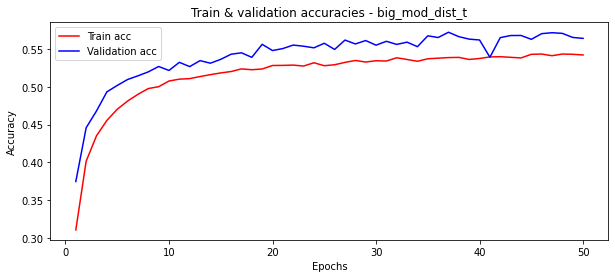

In [ ]:
modelize(model_dist, 50, data_dist, "big_mod_dist_t")

<br><img src="images/distilbert_big_t.png" width = "600" heights = "336">

In [ ]:
for layer in model_dist.layers :
    layer.trainable = True
    
model_dist.layers[-1].trainable = False

model_dist.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5),
                       loss = 'binary_crossentropy',
                       metrics='accuracy')

Epoch 1/20


1000/1000 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.6576WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


1000/1000 [==============================] - 122s 83ms/step - loss: 0.0768 - accuracy: 0.6576 - val_loss: 0.0685 - val_accuracy: 0.6805
Epoch 2/20
1000/1000 [==============================] - 80s 80ms/step - loss: 0.0605 - accuracy: 0.7099 - val_loss: 0.0623 - val_accuracy: 0.7096
Epoch 3/20
1000/1000 [==============================] - 79s 79ms/step - loss: 0.0528 - accuracy: 0.7330 - val_loss: 0.0614 - val_accuracy: 0.7066
Epoch 4/20
1000/1000 [==============================] - 79s 79ms/step - loss: 0.0463 - accuracy: 0.7535 - val_loss: 0.0630 - val_accuracy: 0.7181
Epoch 5/20
1000/1000 [==============================] - 79s 79ms/step - loss: 0.0398 - accuracy: 0.7742 - val_loss: 0.0649 - val_accuracy: 0.7184
Epoch 6/20
1000/1000 [==============================] - 79s 79ms/step - loss: 0.0337 - accuracy: 0.7903 - val_loss: 0.0689 - val_accuracy: 0.7213
Epoch 7/20
1000/1000 [==============================] - 79s 79ms/step - loss: 0.0279 - accuracy: 0.8099 - val_loss: 0.0761 - val_accur

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 20 epochs : 1643 secondes.
Meilleure train_acc = 0.866, meilleure val_acc = 0.721

F1_score obtenu : 0.78


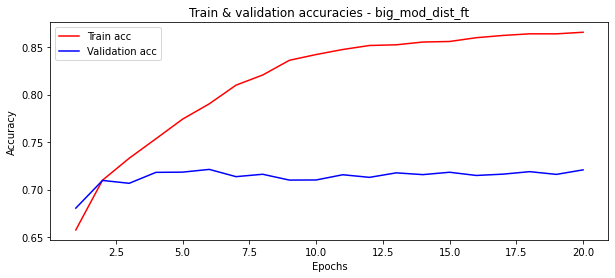

In [ ]:
modelize(model_dist, 20, data_dist, "big_mod_dist_ft")

<br><img src="images/distilbert_big_ft.png" width = "600" heights = "336">

In [ ]:
results_big = dict()

results_big["DistilBert"] = {"Training" : (0.572, 0.51), "Fine-Tuning": (0.721, 0.78)}

pickle_out = open(path_data + "results_big.pickle", "wb")
pickle.dump(results_big, pickle_out)
pickle_out.close()

## **2-) Modèle BERT**

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
start = time()
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)

data_bert = [[X_train_ids, X_train_attention], y_train, [X_test_ids, X_test_attention], y_test]

print(f"L'encodage a pris : {time()-start:.0f} secondes.")

L'encodage a pris : 154 secondes.


In [ ]:
def build_bert_model(max_length = MAX_LENGTH):
                    

    bert = TFBertModel.from_pretrained('bert-base-uncased')

    for layer in bert.layers:
        layer.trainable = False

    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')

    last_hidden_state = bert([input_ids_layer, input_attention_layer])[0]

    cls_token = last_hidden_state[:, 0, :]

    output = tf.keras.layers.Dense(25, activation='sigmoid')(cls_token)
    
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    model.compile(tf.keras.optimizers.Adam(),
                  loss = 'binary_crossentropy',
                  metrics='accuracy')

    return model

In [ ]:
with strategy.scope():
    model_bert = build_bert_model()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/50


 999/1000 [============================>.] - ETA: 0s - loss: 0.1735 - accuracy: 0.3093WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


1000/1000 [==============================] - 71s 56ms/step - loss: 0.1734 - accuracy: 0.3093 - val_loss: 0.1524 - val_accuracy: 0.3744
Epoch 2/50
1000/1000 [==============================] - 50s 50ms/step - loss: 0.1496 - accuracy: 0.3937 - val_loss: 0.1391 - val_accuracy: 0.4400
Epoch 3/50
1000/1000 [==============================] - 50s 50ms/step - loss: 0.1419 - accuracy: 0.4247 - val_loss: 0.1325 - val_accuracy: 0.4566
Epoch 4/50
1000/1000 [==============================] - 50s 50ms/step - loss: 0.1374 - accuracy: 0.4414 - val_loss: 0.1288 - val_accuracy: 0.4749
Epoch 5/50
1000/1000 [==============================] - 50s 50ms/step - loss: 0.1346 - accuracy: 0.4530 - val_loss: 0.1265 - val_accuracy: 0.4835
Epoch 6/50
1000/1000 [==============================] - 50s 50ms/step - loss: 0.1326 - accuracy: 0.4568 - val_loss: 0.1254 - val_accuracy: 0.4875
Epoch 7/50
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1313 - accuracy: 0.4620 - val_loss: 0.1234 - val_accura

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 50 epochs : 2612 secondes.
Meilleure train_acc = 0.488, meilleure val_acc = 0.538

F1_score obtenu : 0.44


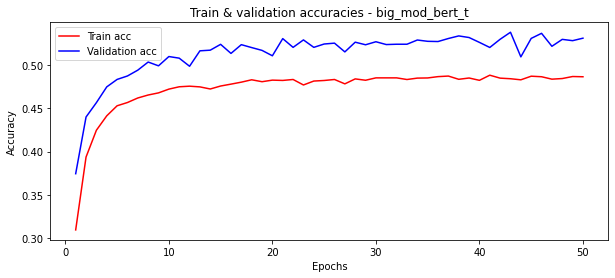

In [ ]:
modelize(model_bert, 50, data_bert, "big_mod_bert_t")

<br><img src="images/bert_big_t.png" width = "600" heights = "336">

In [ ]:
for layer in model_bert.layers :
    layer.trainable = True
    
model_bert.layers[-1].trainable = False

model_bert.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5),
                       loss = 'binary_crossentropy',
                       metrics='accuracy')

Epoch 1/20


1000/1000 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.6645WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


1000/1000 [==============================] - 210s 148ms/step - loss: 0.0764 - accuracy: 0.6645 - val_loss: 0.0670 - val_accuracy: 0.6990
Epoch 2/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.0593 - accuracy: 0.7162 - val_loss: 0.0606 - val_accuracy: 0.7171
Epoch 3/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.0511 - accuracy: 0.7397 - val_loss: 0.0604 - val_accuracy: 0.7161
Epoch 4/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.0444 - accuracy: 0.7621 - val_loss: 0.0603 - val_accuracy: 0.7259
Epoch 5/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.0379 - accuracy: 0.7809 - val_loss: 0.0633 - val_accuracy: 0.7251
Epoch 6/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.0315 - accuracy: 0.8014 - val_loss: 0.0706 - val_accuracy: 0.7236
Epoch 7/20
1000/1000 [==============================] - 141s 141ms/step - loss: 0.0261 - accuracy: 0.8168 - val_loss: 0.079

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 20 epochs : 2947 secondes.
Meilleure train_acc = 0.863, meilleure val_acc = 0.726

F1_score obtenu : 0.79


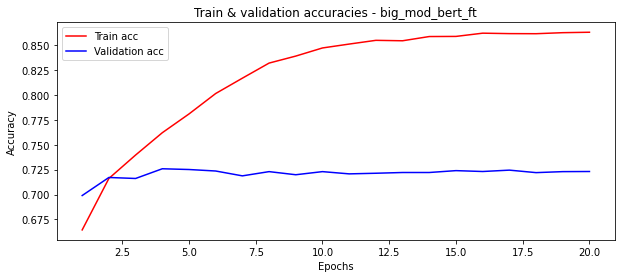

In [ ]:
modelize(model_bert, 20, data_bert, "big_mod_bert_ft")

<br><img src="images/bert_big_ft.png" width = "600" heights = "336">

In [ ]:
results_big["Bert"] = {"Training" : (0.538, 0.44), "Fine-Tuning": (0.726, 0.79)}

pickle_out = open(path_data + "results_big.pickle", "wb")
pickle.dump(results_big, pickle_out)
pickle_out.close()

## **3-) Modèle SciBert**

In [ ]:
model_name = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
start = time()

X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)

data_sci = [[X_train_ids, X_train_attention], y_train, [X_test_ids, X_test_attention], y_test]

print(f"L'encodage a pris : {time()-start:.0f} secondes.")

L'encodage a pris : 48 secondes.


In [ ]:
def build_sci_model(max_length = MAX_LENGTH):

    sci_mod = TFAutoModel.from_pretrained('allenai/scibert_scivocab_uncased', from_pt=True)#, config = config)

    for layer in sci_mod.layers:
        layer.trainable = False

    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')

    last_hidden_state = sci_mod([input_ids_layer, input_attention_layer])[0]

    cls_token = last_hidden_state[:, 0, :]

    output = tf.keras.layers.Dense(25, activation='sigmoid')(cls_token)
    
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    model.compile(tf.keras.optimizers.Adam(),
                  loss = 'binary_crossentropy',
                  metrics='accuracy')

    return model

In [ ]:
with strategy.scope():
    model_sci = build_sci_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

Epoch 1/50


 999/1000 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.2994WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


1000/1000 [==============================] - 71s 55ms/step - loss: 0.1767 - accuracy: 0.2993 - val_loss: 0.1550 - val_accuracy: 0.3739
Epoch 2/50
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1542 - accuracy: 0.3712 - val_loss: 0.1472 - val_accuracy: 0.3980
Epoch 3/50
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1478 - accuracy: 0.3978 - val_loss: 0.1421 - val_accuracy: 0.4284
Epoch 4/50
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1447 - accuracy: 0.4056 - val_loss: 0.1394 - val_accuracy: 0.4318
Epoch 5/50
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1426 - accuracy: 0.4145 - val_loss: 0.1376 - val_accuracy: 0.4443
Epoch 6/50
1000/1000 [==============================] - 50s 50ms/step - loss: 0.1411 - accuracy: 0.4191 - val_loss: 0.1354 - val_accuracy: 0.4526
Epoch 7/50
1000/1000 [==============================] - 50s 50ms/step - loss: 0.1403 - accuracy: 0.4255 - val_loss: 0.1331 - val_accura

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 50 epochs : 2634 secondes.
Meilleure train_acc = 0.443, meilleure val_acc = 0.493

F1_score obtenu : 0.32


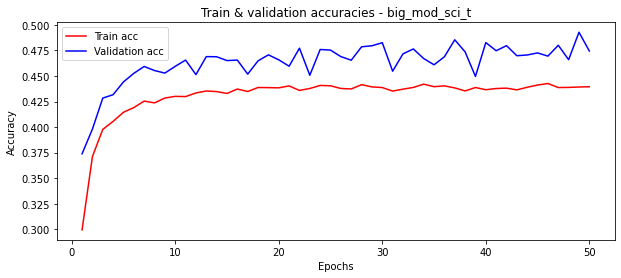

In [ ]:
modelize(model_sci, 50, data_sci, "big_mod_sci_t")

<br><img src="images/scibert_big_t.png" width = "600" heights = "336">

**Fine-tuning SciBert**

In [ ]:
for layer in model_sci.layers :
    layer.trainable = True
    
model_sci.layers[-1].trainable = False

model_sci.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5),
                       loss = 'binary_crossentropy',
                       metrics='accuracy')

Epoch 1/20


1000/1000 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.6647WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


1000/1000 [==============================] - 212s 149ms/step - loss: 0.0757 - accuracy: 0.6647 - val_loss: 0.0639 - val_accuracy: 0.6908
Epoch 2/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.0579 - accuracy: 0.7150 - val_loss: 0.0604 - val_accuracy: 0.7089
Epoch 3/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.0491 - accuracy: 0.7424 - val_loss: 0.0588 - val_accuracy: 0.7191
Epoch 4/20
1000/1000 [==============================] - 143s 143ms/step - loss: 0.0412 - accuracy: 0.7698 - val_loss: 0.0617 - val_accuracy: 0.7215
Epoch 5/20
1000/1000 [==============================] - 143s 143ms/step - loss: 0.0339 - accuracy: 0.7918 - val_loss: 0.0670 - val_accuracy: 0.7239
Epoch 6/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.0271 - accuracy: 0.8125 - val_loss: 0.0715 - val_accuracy: 0.7198
Epoch 7/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.0214 - accuracy: 0.8316 - val_loss: 0.079

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 20 epochs : 2958 secondes.
Meilleure train_acc = 0.862, meilleure val_acc = 0.724

F1_score obtenu : 0.79


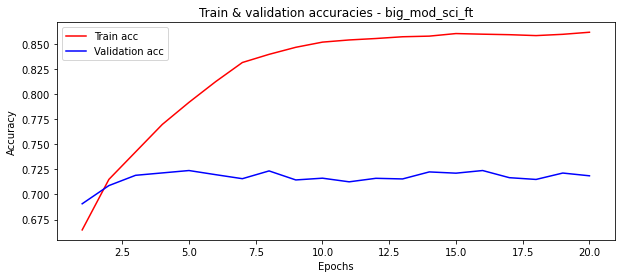

In [ ]:
modelize(model_sci, 20, data_sci, "big_mod_sci_ft")

<br><img src="images/scibert_big_ft.png" width = "600" heights = "336">

In [ ]:
results_big["SciBert"] = {"Training" : (0.493, 0.32), "Fine-Tuning": (0.724, 0.79)}

pickle_out = open(path_data + "results_big.pickle", "wb")
pickle.dump(results_big, pickle_out)
pickle_out.close()

## **4-) Modèle RoBERTa**

In [ ]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
start = time()
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)

data_berta = [[X_train_ids, X_train_attention], y_train, [X_test_ids, X_test_attention], y_test]

print(f"L'encodage a pris : {time()-start:.0f} secondes.")

L'encodage a pris : 52 secondes.


In [ ]:
def build_berta_model(max_length = MAX_LENGTH):
                    
    roberta = TFRobertaModel.from_pretrained("roberta-base")#, config = config)

    for layer in roberta.layers:
        layer.trainable = False

    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')

    last_hidden_state = roberta([input_ids_layer, input_attention_layer])[0]

    cls_token = last_hidden_state[:, 0, :]
    
    output = tf.keras.layers.Dense(25, activation='sigmoid')(cls_token)
    
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    model.compile(tf.keras.optimizers.Adam(),
                  loss = 'binary_crossentropy',
                  metrics='accuracy')

    return model

In [ ]:
with strategy.scope():
    model_berta = build_berta_model()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50


 999/1000 [============================>.] - ETA: 0s - loss: 0.2094 - accuracy: 0.2197WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


1000/1000 [==============================] - 71s 56ms/step - loss: 0.2094 - accuracy: 0.2198 - val_loss: 0.1801 - val_accuracy: 0.2319
Epoch 2/50
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1797 - accuracy: 0.2668 - val_loss: 0.1702 - val_accuracy: 0.3099
Epoch 3/50
1000/1000 [==============================] - 52s 52ms/step - loss: 0.1695 - accuracy: 0.3149 - val_loss: 0.1630 - val_accuracy: 0.3686
Epoch 4/50
1000/1000 [==============================] - 52s 52ms/step - loss: 0.1629 - accuracy: 0.3434 - val_loss: 0.1566 - val_accuracy: 0.3768
Epoch 5/50
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1583 - accuracy: 0.3660 - val_loss: 0.1521 - val_accuracy: 0.3938
Epoch 6/50
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1545 - accuracy: 0.3832 - val_loss: 0.1483 - val_accuracy: 0.4029
Epoch 7/50
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1523 - accuracy: 0.3970 - val_loss: 0.1452 - val_accura

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 50 epochs : 2821 secondes.
Meilleure train_acc = 0.493, meilleure val_acc = 0.547

F1_score obtenu : 0.29


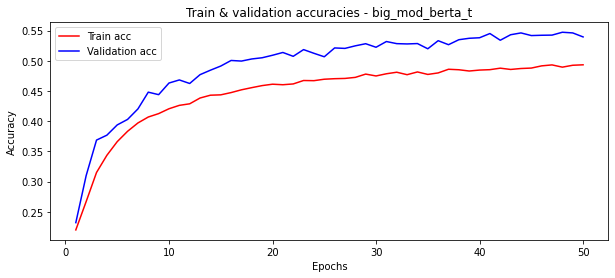

In [ ]:
modelize(model_berta, 50, data_berta, "big_mod_berta_t")

<br><img src="images/berta_big_t.png" width = "600" heights = "336">

**Fine-tuning**

In [ ]:
for layer in model_berta.layers :
    layer.trainable = True
    
model_berta.layers[-1].trainable = False

model_berta.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5),
                       loss = 'binary_crossentropy',
                       metrics='accuracy')

Epoch 1/20


1000/1000 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.6558WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


1000/1000 [==============================] - 212s 152ms/step - loss: 0.0825 - accuracy: 0.6558 - val_loss: 0.0665 - val_accuracy: 0.6923
Epoch 2/20
1000/1000 [==============================] - 147s 147ms/step - loss: 0.0670 - accuracy: 0.7000 - val_loss: 0.0622 - val_accuracy: 0.7161
Epoch 3/20
1000/1000 [==============================] - 147s 147ms/step - loss: 0.0593 - accuracy: 0.7222 - val_loss: 0.0641 - val_accuracy: 0.7180
Epoch 4/20
1000/1000 [==============================] - 147s 147ms/step - loss: 0.0542 - accuracy: 0.7375 - val_loss: 0.0593 - val_accuracy: 0.7201
Epoch 5/20
1000/1000 [==============================] - 148s 148ms/step - loss: 0.0488 - accuracy: 0.7501 - val_loss: 0.0614 - val_accuracy: 0.7224
Epoch 6/20
1000/1000 [==============================] - 147s 147ms/step - loss: 0.0439 - accuracy: 0.7663 - val_loss: 0.0599 - val_accuracy: 0.7261
Epoch 7/20
1000/1000 [==============================] - 147s 147ms/step - loss: 0.0399 - accuracy: 0.7789 - val_loss: 0.062

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>]



Temps d'entrainements pour 20 epochs : 3055 secondes.
Meilleure train_acc = 0.854, meilleure val_acc = 0.726

F1_score obtenu : 0.79


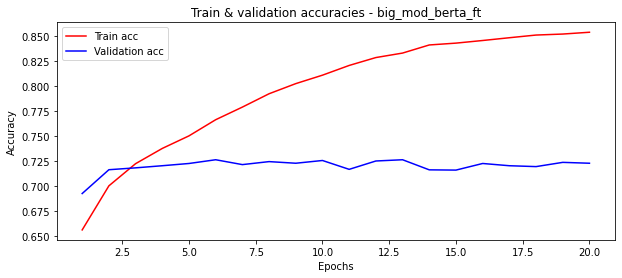

In [ ]:
modelize(model_berta, 20, data_berta, "big_mod_berta_ft")

<br><img src="images/berta_big_ft.png" width = "600" heights = "336">

In [ ]:
results_big["Roberta"] = {"Training" : (0.547, 0.29), "Fine-Tuning": (0.726, 0.79)}

pickle_out = open(path_data + "results_big.pickle", "wb")
pickle.dump(results_big, pickle_out)
pickle_out.close()

## **Résultats finaux**

In [ ]:
res = pd.DataFrame.from_dict(results_big, orient='index')
res

,Training,Fine-Tuning
DistilBert,"(0.572, 0.51)","(0.721, 0.78)"
Bert,"(0.538, 0.44)","(0.726, 0.79)"
SciBert,"(0.493, 0.32)","(0.724, 0.79)"
Roberta,"(0.547, 0.29)","(0.726, 0.79)"


Travailler sur un nouveau dataset deux fois plus conséquent que le premier n'a pas eu l'effet escompté. Cette démarche a juste permis de gagner un point au F1_score_weighted avec trois de nos quatre modèles.<br><br>Même si avec les modèles **BERT** nous avons gagné 10 points par rapport à ce que nous avions obtenu lors du **Projet 5**, et que donc ce **projet 7** est un succès, nous avons peut-être atteint les limites de leurs capacités. Ou tout du moins, les possibilités d'amélioration significative étaient ailleurs.

**Fin**